## Tutorial 2: Variational Trajectory Planning - Build a motion planner and upload benchmark solutions

https://commonroad.in.tum.de/tutorials/optimization-solution

## Exercise 0: Read the created CommonRoad scenario

The CommonRoadFileReader reads the Scenario and the PlanningProblemSet from a CommonRoad XML-file. Please read the scenario from the CommonRoad file.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

import numpy as np

/home/commonroad/Desktop/Software/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/commonroad/geometry/shape.py:314: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.lanelet_id = lanelet_id
/home/commonroad/Desktop/Software/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


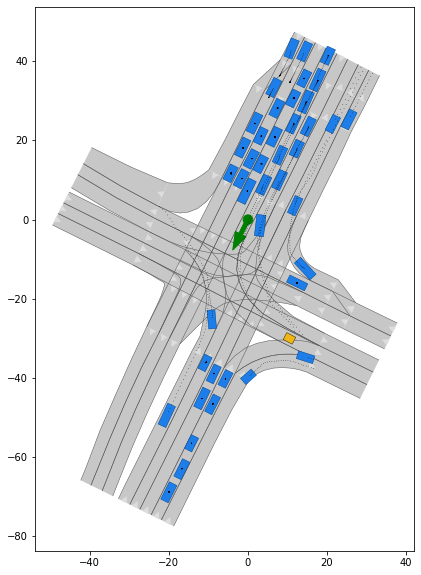

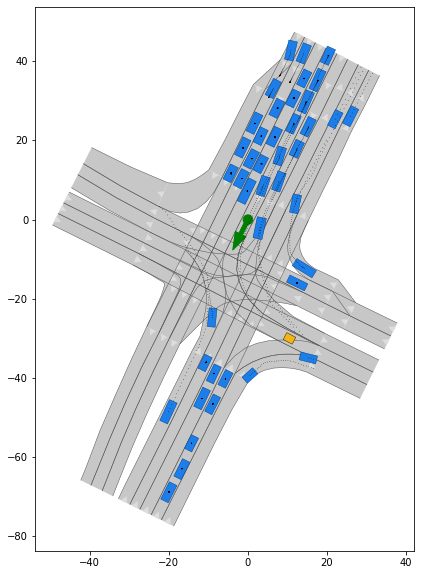

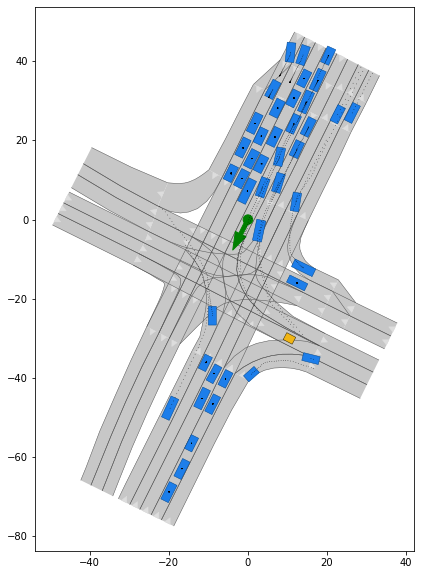

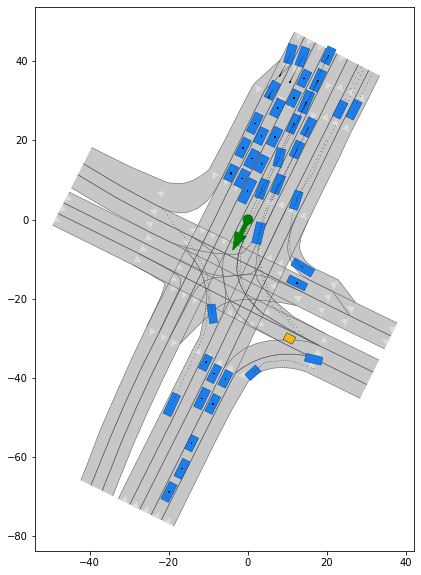

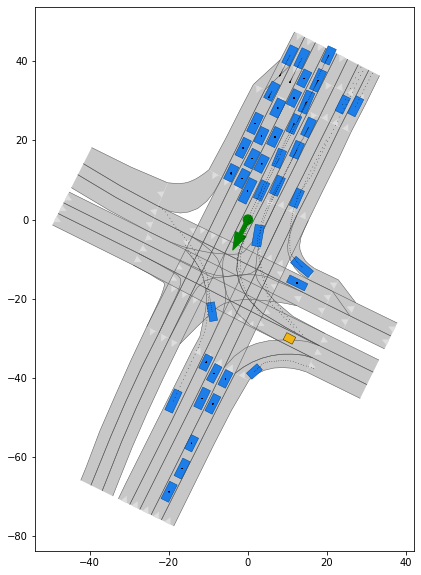

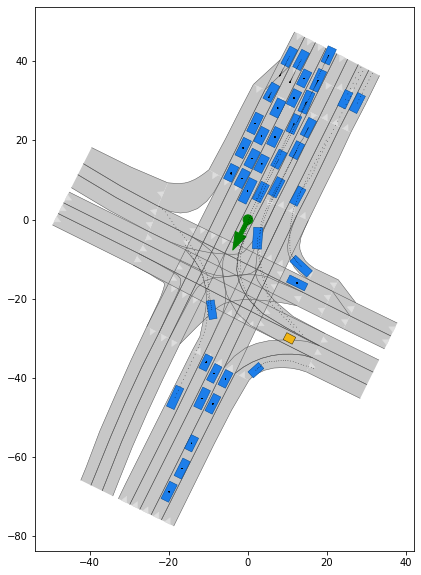

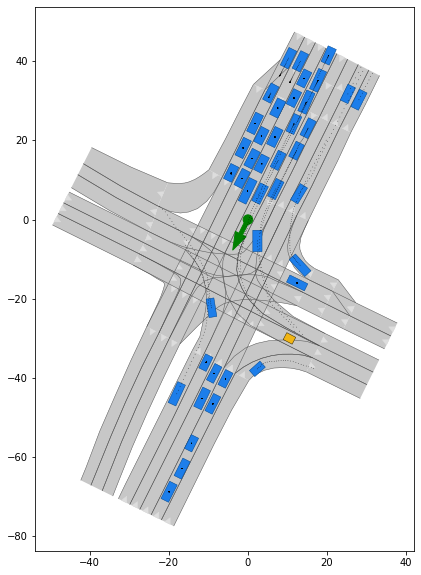

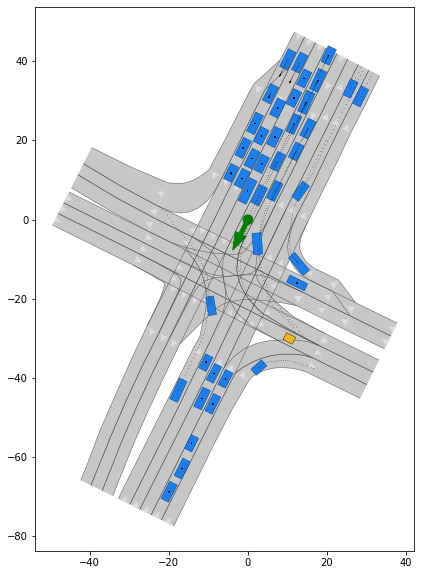

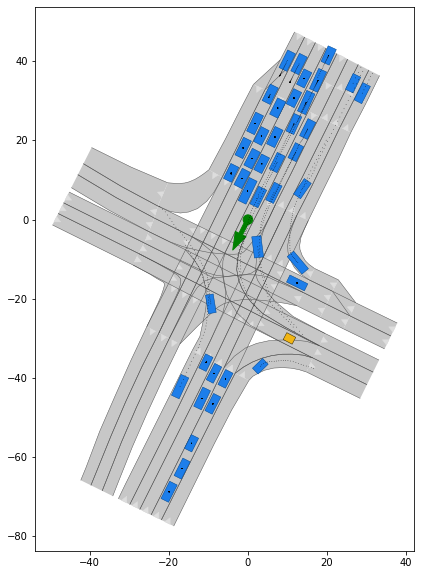

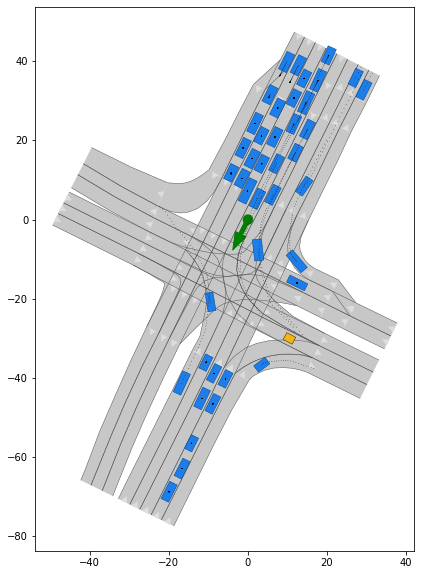

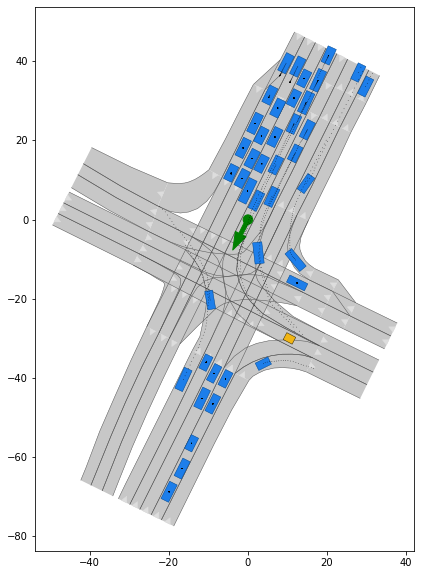

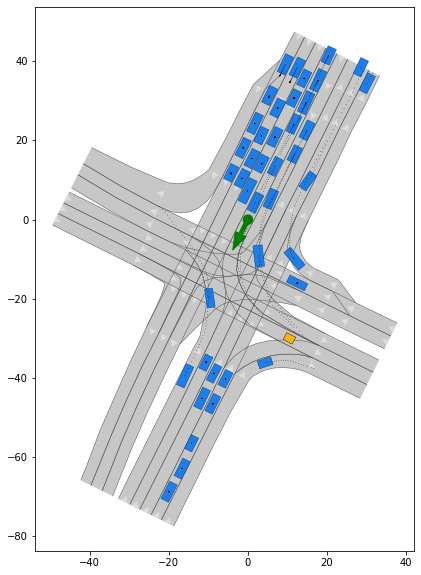

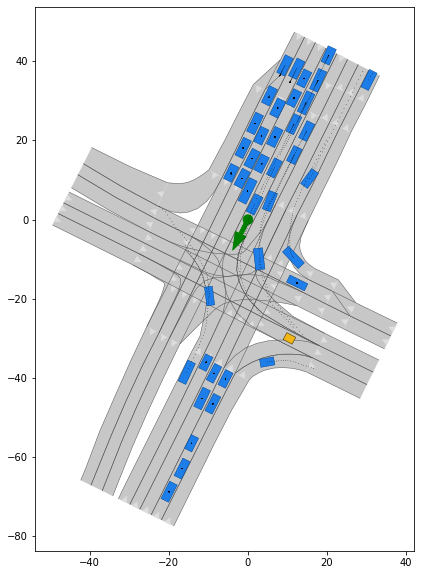

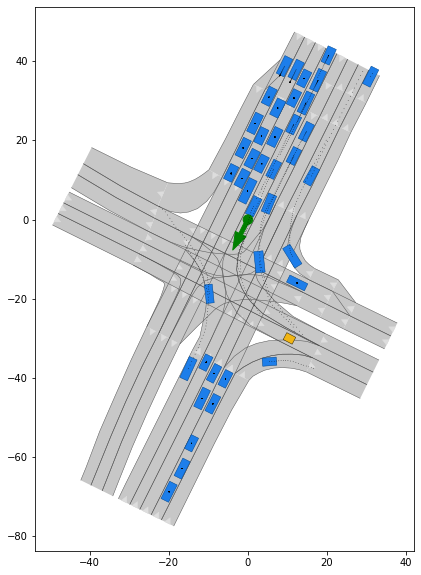

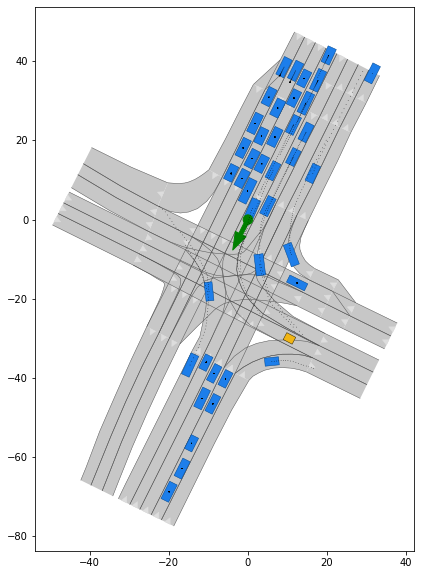

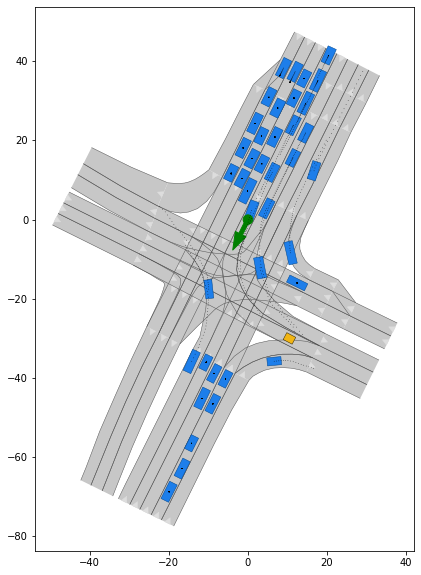

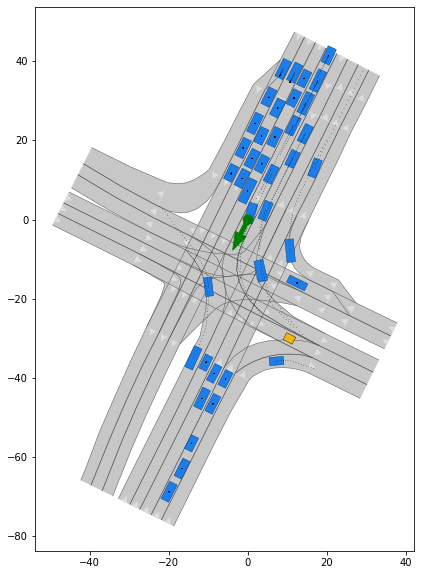

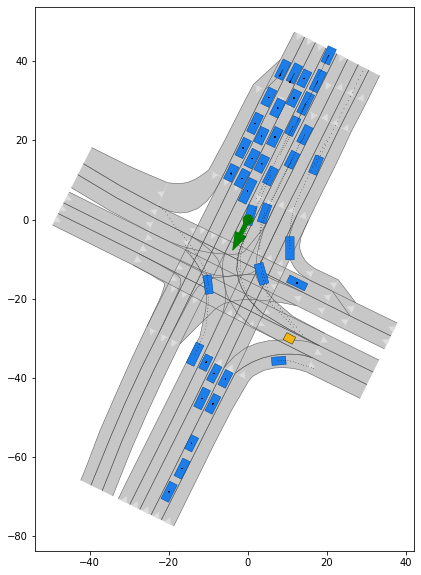

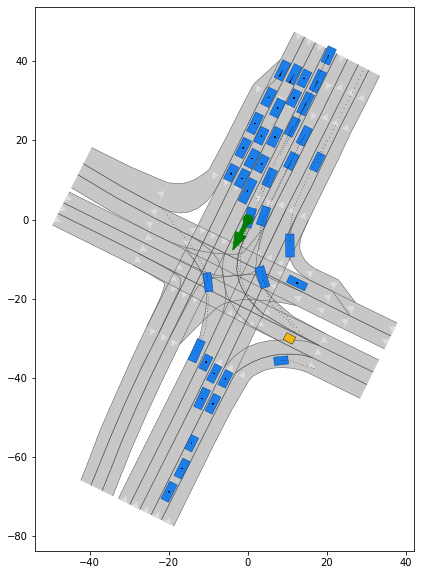

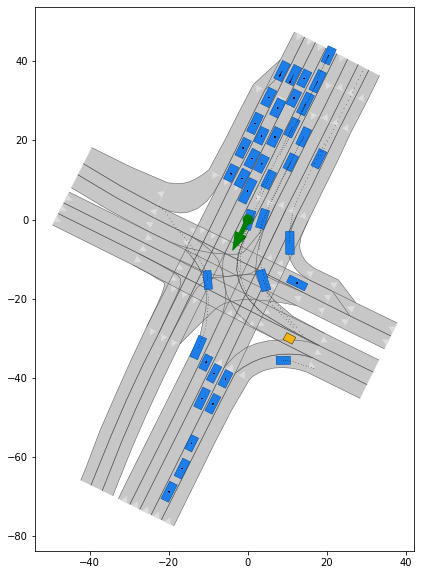

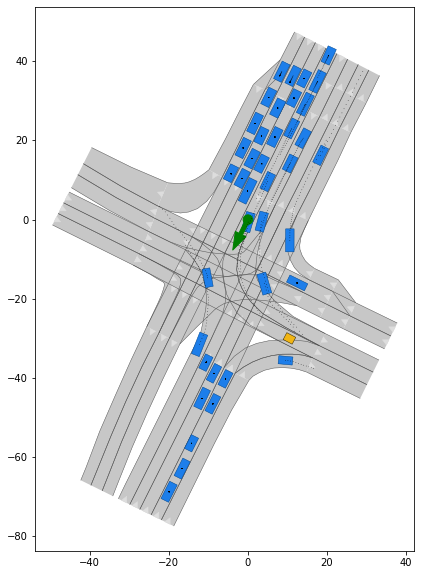

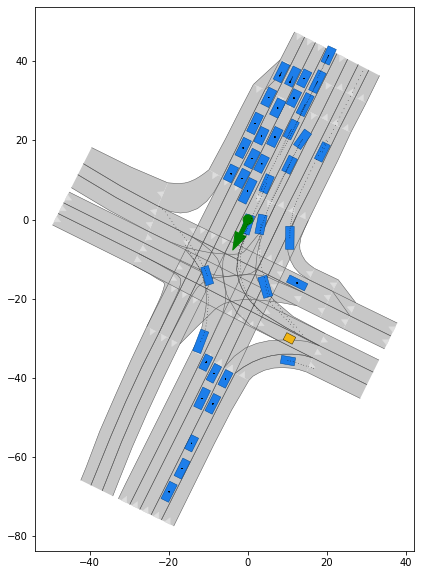

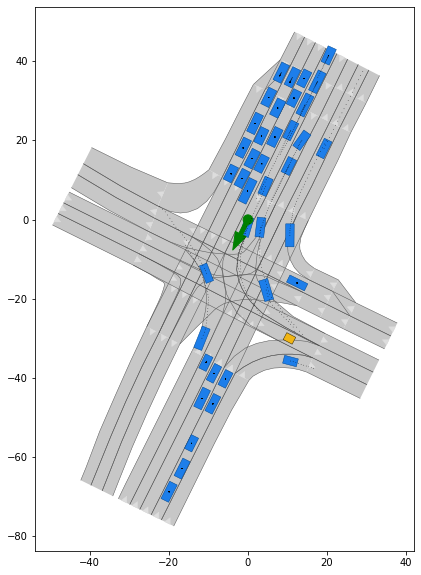

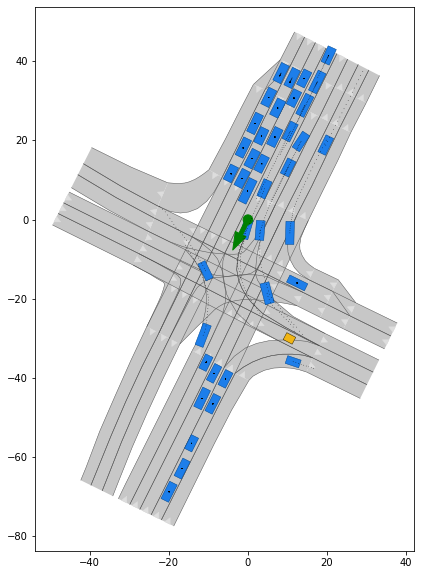

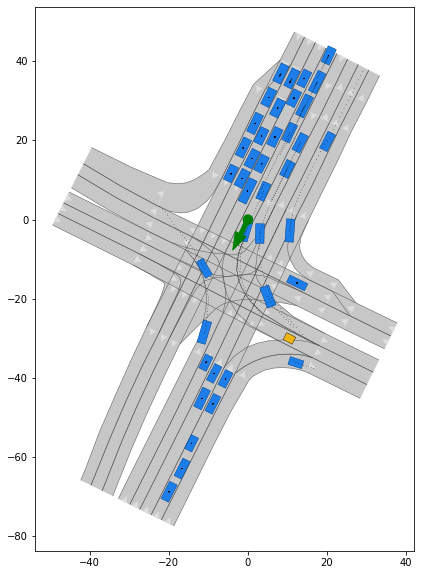

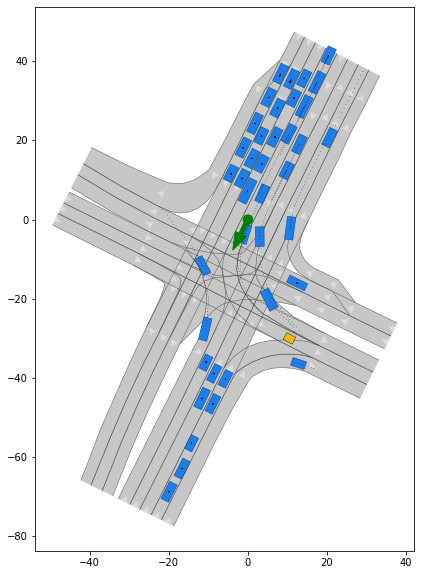

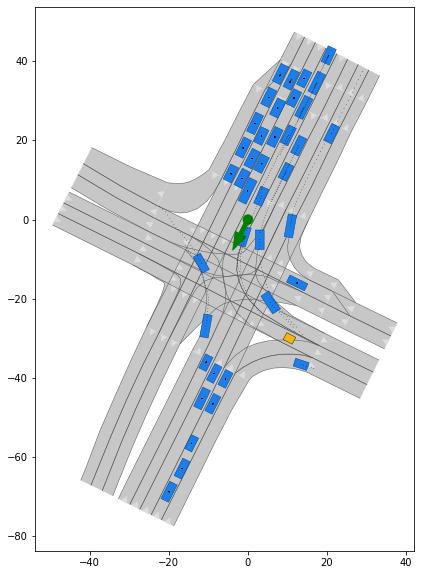

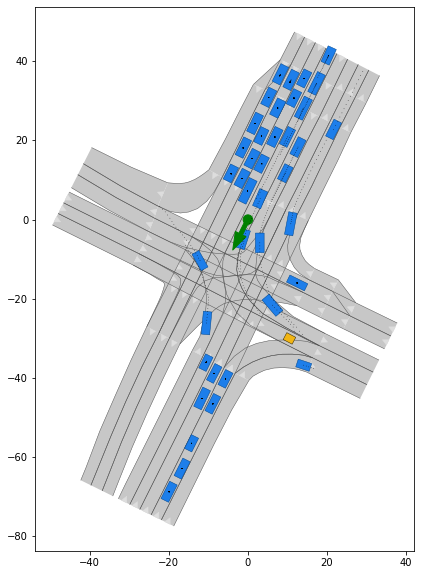

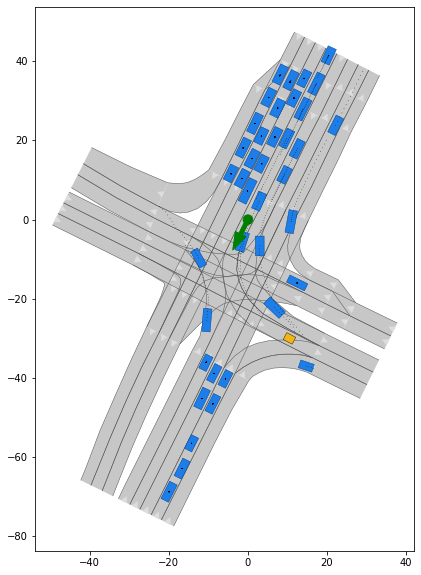

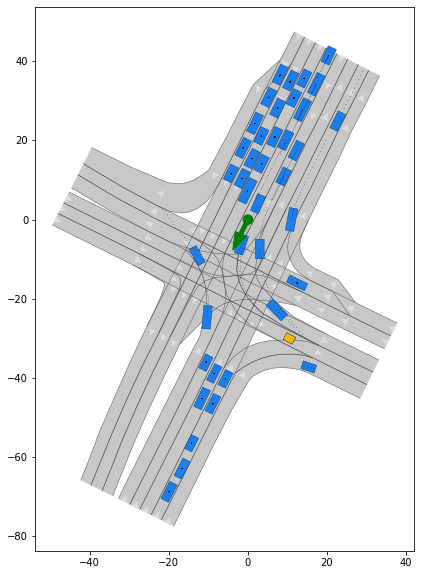

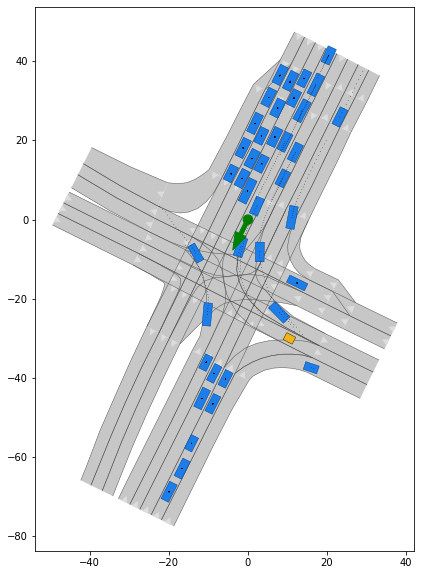

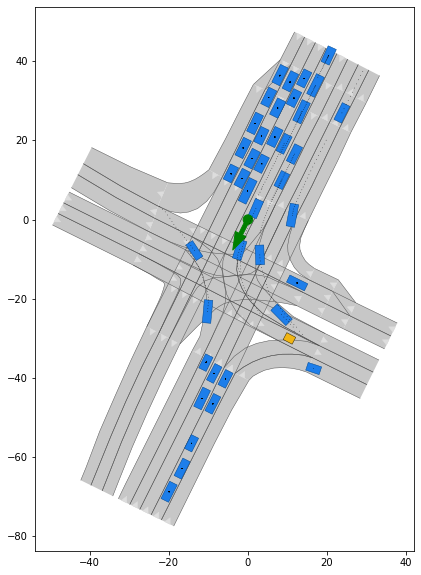

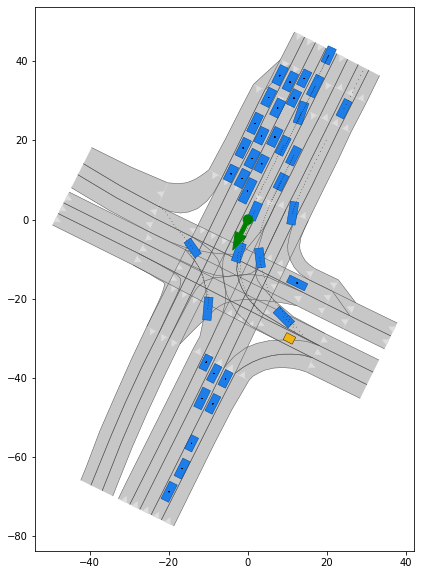

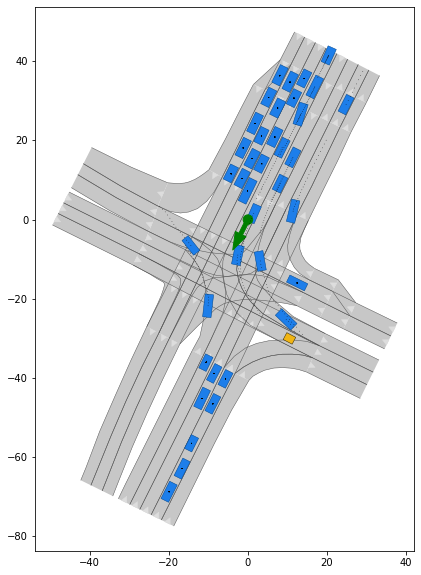

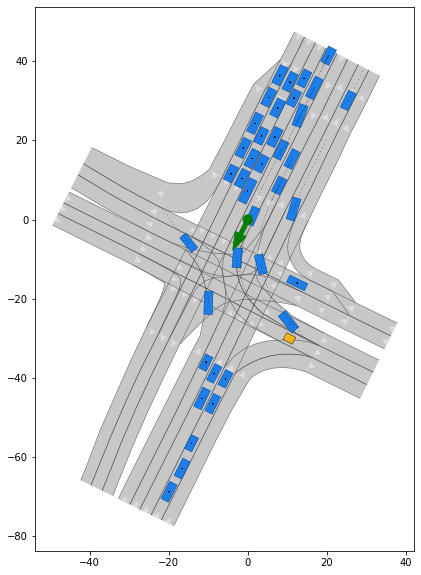

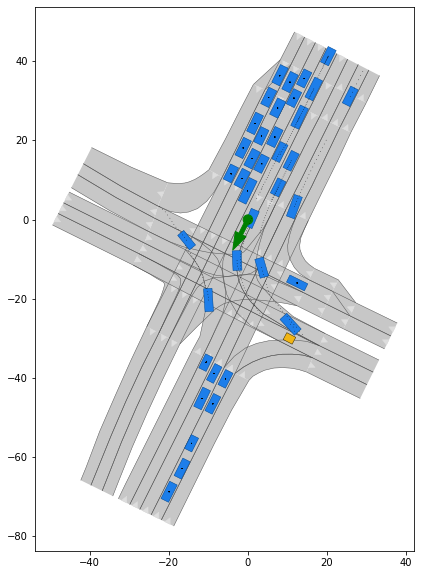

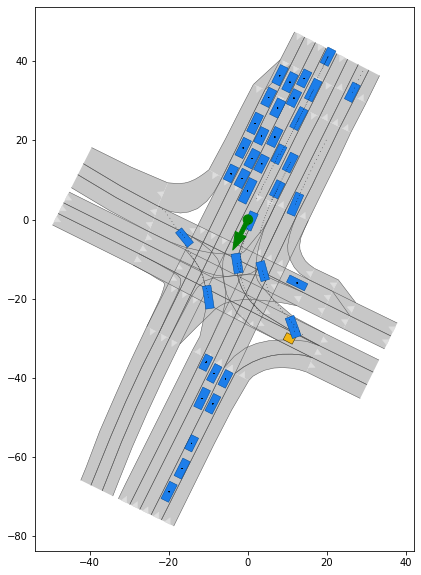

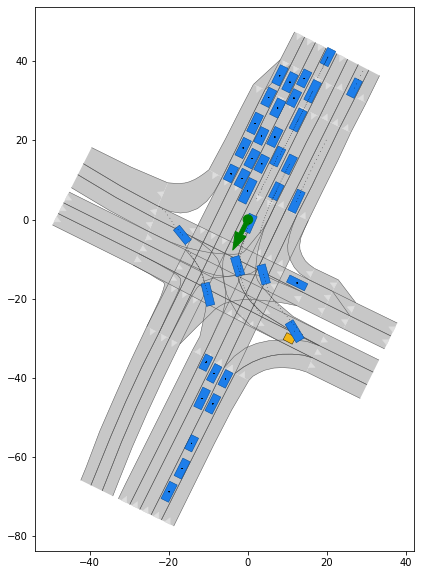

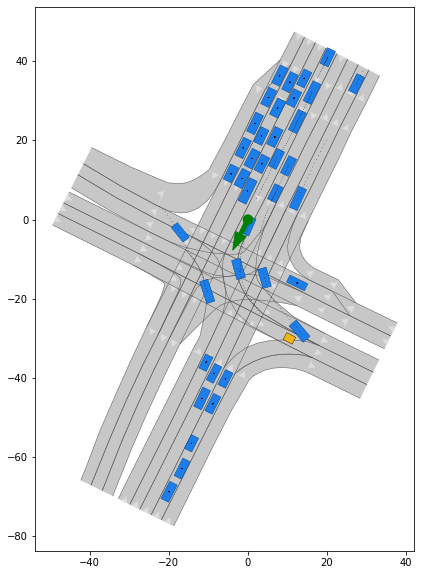

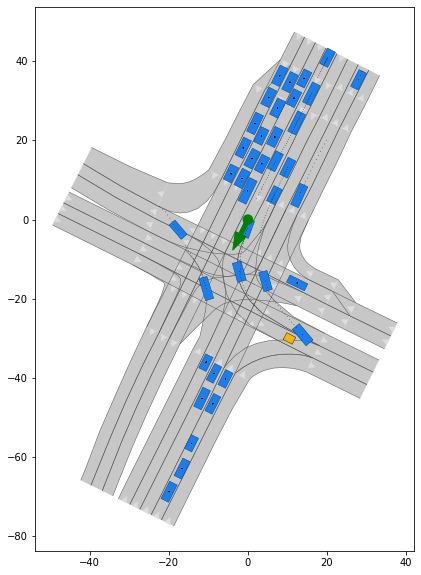

In [2]:
# load the CommonRoad scenario that has been created in the CommonRoad tutorial
# file_path = os.path.join(os.getcwd(), 'ZAM_Tutorial-1_2_T-1.xml')
# file_path = os.path.join(os.getcwd(), 'scenarios/tutorial/ZAM_Tutorial-1_2_T-2.xml')

# downloaded .xml manually from https://commonroad.in.tum.de/scenarios directly
path_notebook = os.getcwd()
path_scenario = os.path.join(path_notebook, "./scenarios/exercise/")
id_scenario = 'USA_Lanker-1_2_T-1'

#file_path = os.path.join(os.getcwd(), 'download/ZAM_Tutorial-1_2_T-1.xml')
file_path = path_scenario + id_scenario + '.xml'

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.savefig('figure/basic/{}.JPG'.format(i))

In [3]:
import glob

import imageio as io

#import gifmaker

def make_gif(frame_folder):
    frames = [io.imread(f"{frame_folder}/{i}.JPG") for i in range(40)]
    print(len(frames))
    #frame_one = frames[0]
    #frame_one.save(f"{frame_folder}.gif", format = "GIF", append_images = frames[1:], 
    #               save_ALL = True, duration = 100, loop = 1)
    io.mimsave(f"{frame_folder}.gif", frames, duration = 0.5)
    #fp = open(f"{frame_folder}.gif", "wb")
    #gifmaker.makedelta(fp, frames)

    
make_gif("./figure/basic")


40


## Helper Functions for visualization

In [4]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    print('Matplotlib not installed. Please use pip(3) to install required package!')

try:
    import numpy as npy
except ImportError:
    print('Numpy not installed. Please use pip(3) to install required package!')

try:
    import vehiclemodels
except ImportError:
    print('commonroad-vehicle-models not installed. Please use pip install to install required package!')

try:
    import pkg_resources
    pkg_resources.require("scipy>=1.1.0")
    pkg_resources.require("cvxpy>=1.0.0")
    import cvxpy as cvx
except ImportError:
    print('CVXPy not installed or wrong version. Please use pip(3) to install required package!')

class TIConstraints:
    a_min = -8
    a_max = 15
    s_min = 0
    s_max = 100
    v_min = 0
    v_max = 35
    j_min = -30
    j_max = 30


def plot_state_vector(x : cvx.Variable, c : TIConstraints, s_obj = None):
    plt.figure(figsize=(10,10))
    N = x.shape[1]-1
    #s_max = npy.maximum(c.s_max,100+0*npy.ceil(npy.amax((x.value)[0,:].flatten())*1.1/10)*10)
    s_max = c.s_max

    # Plot (x_t)_1.
    plt.subplot(4,1,1)
    x1 = (x.value)[0,:].flatten()
    plt.plot(npy.array(range(N+1)),x1,'g')
    if s_obj is not None:
        plt.plot(npy.array(range(1,N+1)),s_obj[0],'b')
        plt.plot(npy.array(range(1,N+1)),s_obj[1],'r')
    plt.ylabel(r"$s$", fontsize=16)
    plt.yticks(npy.linspace(c.s_min, s_max, 3))
    plt.ylim([c.s_min, s_max])
    plt.xticks([])

    # Plot (x_t)_2.
    plt.subplot(4,1,2)
    x2 = (x.value)[1,:].flatten()
    plt.plot(npy.array(range(N+1)),x2,'g')
    plt.yticks(npy.linspace(c.v_min,c.v_max,3))
    plt.ylim([c.v_min, c.v_max+2])
    plt.ylabel(r"$v$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_3.
    plt.subplot(4,1,3)
    x2 = (x.value)[2,:].flatten()
    plt.plot(npy.array(range(N+1)),x2,'g')
    plt.yticks(npy.linspace(c.a_min,c.a_max,3))
    plt.ylim([c.a_min, c.a_max+2])
    plt.ylabel(r"$a$", fontsize=16)
    plt.xticks([])

    # Plot (x_t)_4.
    plt.subplot(4,1,4)
    x2 = (x.value)[3,:].flatten()
    plt.plot(npy.array(range(N+1)), x2,'g')
    plt.yticks(npy.linspace(c.j_min,c.j_max,3))
    plt.ylim([c.j_min-1, c.j_max+1])
    plt.ylabel(r"$j$", fontsize=16)
    plt.xticks(npy.arange(0,N+1,5))
    plt.xlabel(r"$k$", fontsize=16)
    plt.tight_layout()
    
    plt.savefig('./figure/probsolve.JPG')
    
    plt.show()

## Variables of the Optimization Problem

In [5]:
# problem data
N  = 40  # number of time steps
n  = 4   # length of state vector 
m  = 1   # length of input vector
dT = scenario.dt # time step


# set up variables
x = cvx.Variable(shape=(n,N+1)) # optimization vector x contains n states per time step 
u = cvx.Variable(shape=(N)) # optimization vector u contains 1 state

# set up constraints
c = TIConstraints()
c.a_min = -6 # Minimum feasible acceleration of vehicle
c.a_max = 6 # Maximum feasible acceleration of vehicle
c.s_min = -100 # Minimum allowed position
c.s_max = 100 # Maximum allowed position
c.v_min = 0 # Minimum allowed velocity (no driving backwards!)
c.v_max = 35 # Maximum allowed velocity (speed limit)
c.j_min = -15 # Minimum allowed jerk 
c.j_max = 15 # Maximum allowed jerk

# weights for cost function
w_s = 0
w_v = 8
w_a = 2
w_j = 2
Q = npy.eye(n)*npy.transpose(npy.array([w_s,w_v,w_a,w_j]))
w_u = 1
R = w_u

In [6]:
## Exercise 1: Consider the vehicle model

In order to obtain kinematically feasible motion plans, the optimization problem needs to respect the constraints of the vehicle model. We use a linear vehicle model, which can be written in the following state-space form:

Please fill the matrices A and B according to the fourth-order point-mass model, discretized using the time step dT.

In [7]:
A = npy.array([[1,dT,(dT**2)/2,(dT**3)/6],
               [0,1,dT,(dT**2)/2],
               [0,0,1,dT],
               [0,0,0,1]])
B = npy.array([(dT**4)/24,
               (dT**3)/6,
               (dT**2)/2,
               dT]).reshape([n,])

## Formulation of the Optimization Problem

In [8]:
planning_problem_set.planning_problem_dict.keys()

dict_keys([11425])

We are now able to formulate the optimization problem. Please set the initial state of the ego vehicle with a velocity of 0 m/s and its reference velocity. Subsequently, we create the cost terms and constraints of the optimization problem

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 13 06:56:41 PM: Your problem has 204 variables, 41 constraints, and 0 parameters.
(CVXPY) Mar 13 06:56:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 06:56:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 06:56:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 06:56:42 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 13 06:56:42 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

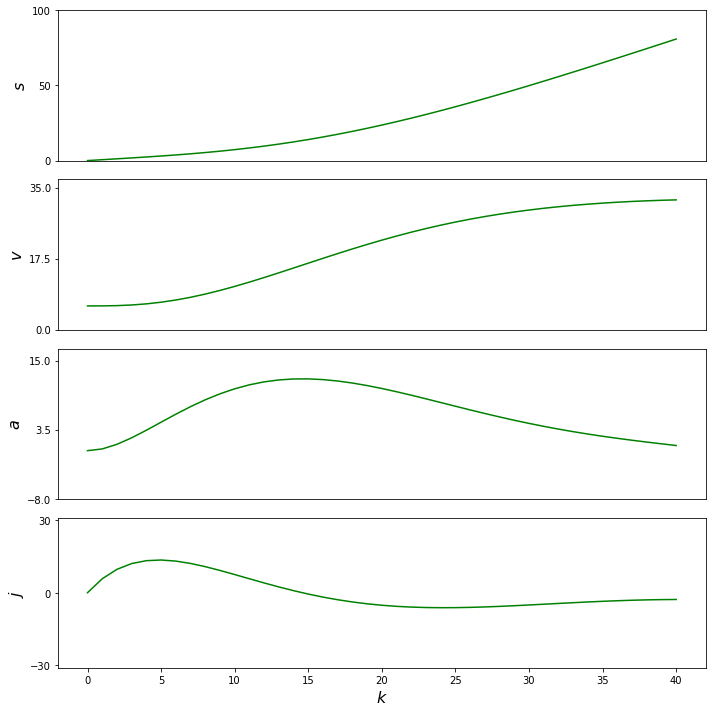

In [9]:
# get the initial state of the ego vehicle from the planning problem set
planning_problem = planning_problem_set.find_planning_problem_by_id(11425)
initial_state = planning_problem.initial_state

# initial state of vehicle for the optimization problem (longitudinal position, velocity, acceleration, jerk)
x_0 = npy.array([initial_state.position[0],
                 initial_state.velocity,
                 0.0,
                 0.0]).reshape([n,]) # initial state

# reference velocity
v_ref = 30.0
# Set up optimization problem
states = []
cost = 0
# initial state constraint
constr = [x[:,0] == x_0]

for k in range(N):
    # cost function
    cost += cvx.quad_form(x[:,k+1] - npy.array([0,v_ref,0,0],), Q)\
           + R * u[k] ** 2
    # time variant state and input constraints
    constr.append(x[:,k+1] == A @ x[:,k] + B * u[k])

# sums problem objectives and concatenates constraints.
# create optimization problem
prob = cvx.Problem(cvx.Minimize(cost), constr)

# Solve optimization problem
prob.solve(verbose=True)
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, TIConstraints())

# Exercise 2: Consider additional constraints
    

The obtained trajectory reaches the desired reference velocity of the ego vehicle. However, the physical constraints are not fulfilled. Please add the physical constraints to the optimization problem in order to obtain kinematically feasible trajectories.

/home/commonroad/Desktop/Software/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/cvxpy/problems/problem.py:1334: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Problem is convex:  True
Problem solution is optimal_inaccurate


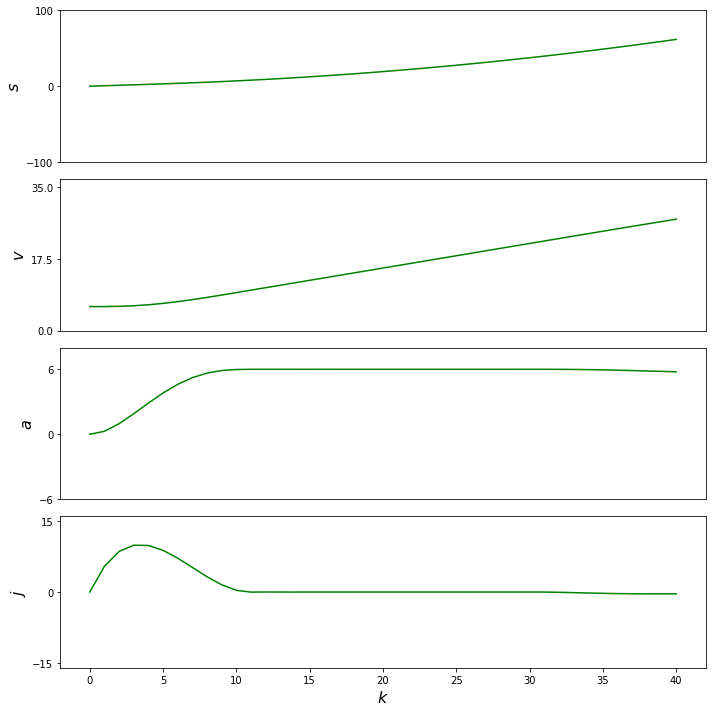

In [10]:
tiConstraints = [x[1,:] <= c.v_max, x[1,:] >= c.v_min] # velocity
tiConstraints += [x[2,:] <= c.a_max, x[2,:] >= c.a_min] # acceleration
tiConstraints += [x[3,:] <= c.j_max, x[3,:] >= c.j_min] # jerk

# Adjust problem
prob = cvx.Problem(cvx.Minimize(cost), constr + tiConstraints)

# Solve optimization problem
prob.solve()
print("Problem is convex: ",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, c)

# Exercise 3: Extract the prediction of obstacles

In our scenario, the ego vehicle is surrounded by two other traffic participants -- one following and one leading vehicle. In order to not cause a collision with these two vehicles, we need to consider the positions of the two vehicles in our optimization problem. Please obtain the minimum and maximum feasible position of the ego vehicle for each point in time. Please note that each obstacle has a certain shape.

Leading vehicle id=1314
Leading vehicle id=1316
Leading vehicle id=1329
Leading vehicle id=1332
Leading vehicle id=1408
Leading vehicle id=1432
Leading vehicle id=1434
Leading vehicle id=1437
Leading vehicle id=1443
Following vehicle id=1458
Following vehicle id=1463
Leading vehicle id=1479
Following vehicle id=1485
Following vehicle id=1487
Leading vehicle id=1489
Leading vehicle id=1492
Following vehicle id=1494
Leading vehicle id=1495
Leading vehicle id=1496
Following vehicle id=1497
Leading vehicle id=1501
Leading vehicle id=1504
Leading vehicle id=1505
Leading vehicle id=1508
Leading vehicle id=1509
Following vehicle id=1513
Following vehicle id=1515
Following vehicle id=1519
Leading vehicle id=1520
Leading vehicle id=1526
Leading vehicle id=1529
Following vehicle id=1535
Following vehicle id=1542
Leading vehicle id=1546
Following vehicle id=1547
Leading vehicle id=1549
Leading vehicle id=1553
Leading vehicle id=1554
Leading vehicle id=1555
Leading vehicle id=1562
Following vehicl

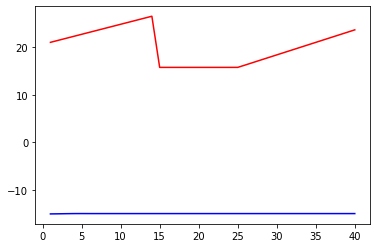

In [11]:
# extract obstacle from scenario
dyn_obstacles = scenario.dynamic_obstacles

# create constraints for minimum and maximum position
s_min = [] # minimum position constraint
s_max = [] # maximum position constraint

# go through obstacle list and distinguish between following and leading vehicle
for o in dyn_obstacles:
    if o.initial_state.position[0] < x_0[0]:
        print('Following vehicle id={}'.format(o.obstacle_id))
        prediction = o.prediction.trajectory.state_list
        for i, p in enumerate(prediction):
            if i >= len(s_min):
                s_min.append(p.position[0]+o.obstacle_shape.length/2.+2.5)
            else:
                s_min[i] = min(s_min[i], p.position[0]+o.obstacle_shape.length/2.+2.5)
    else:
        print('Leading vehicle id={}'.format(o.obstacle_id))
        prediction = o.prediction.trajectory.state_list
        for i, p in enumerate(prediction):    
            if i >= len(s_max):
                s_max.append(p.position[0]-o.obstacle_shape.length/2.-2.5)
                #print(s_max[-1])
            else:
                #print(s_max[i], p.position[0]-o.obstacle_shape.length/2.-2.5)
                s_max[i] = max(s_max[i], p.position[0]-o.obstacle_shape.length/2.-2.5)

                
s_len = 40 
c.s_min = min(s_min )- 5
c.s_max = max(s_max )+ 5
                
# plot vehicle motions
plt.plot(range(1,s_len+1),s_min[:s_len],'b')
plt.plot(range(1,s_len+1),s_max[:s_len],'r')


## Exercise 4: Plan the motion of the ego vehicle

The obtained collision constraint allow us to avoid collisions with the following and leading vehicle. Please add the constraints to our optimization problem and obtain a trajectory.

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 13 06:56:45 PM: Your problem has 204 variables, 127 constraints, and 0 parameters.
(CVXPY) Mar 13 06:56:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 06:56:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 06:56:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 06:56:45 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 13 06:56:45 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

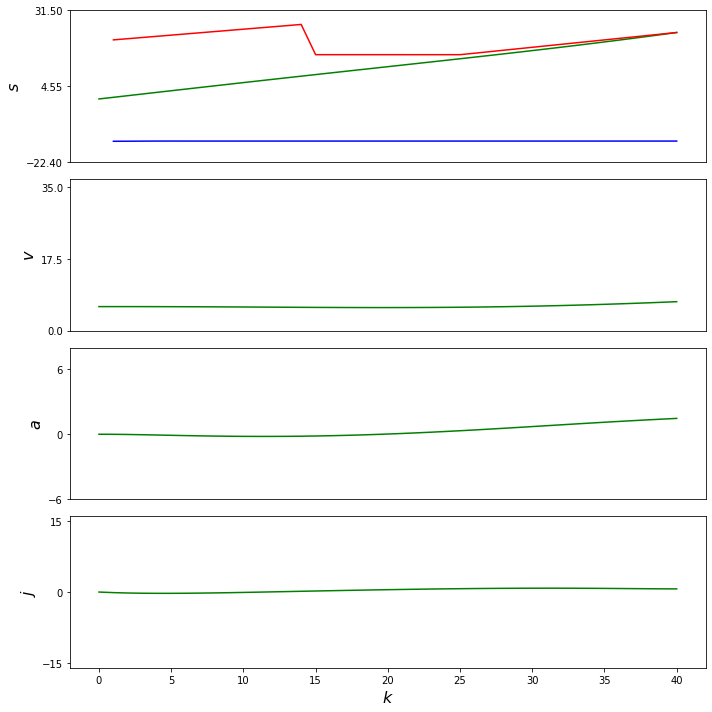

In [12]:
# initial state of ego vehicle
x_0 = npy.array([initial_state.position[0],
                 initial_state.velocity,
                 0,
                 0]).reshape([n,]) # initial state

# reference velocity
v_ref = 30.0

# Set up optimization problem
cost = 0
constr = [x[:,0] == x_0]
for k in range(N):
    # cost function
    cost += cvx.quad_form(x[:,k+1] - npy.array([0,v_ref,0,0],), Q)\
           + R * u[k] ** 2
    # single state and input constraints
    constr.append(x[:,k+1] == A @ x[:,k] + B * u[k])
    # add obstacle constraint
    constr.append(x[0,k+1] <= s_max[k])
    constr.append(x[0,k+1] >= s_min[k])

# sums problem objectives and concatenates constraints.
prob = sum(states)
# add constraints for all states & inputs
prob = cvx.Problem(cvx.Minimize(cost), constr + tiConstraints)


# Solve optimization problem
prob.solve(verbose=True)

print("Problem is convex:",prob.is_dcp())
print("Problem solution is "+prob.status)

# plot results
plot_state_vector(x, c, [s_min[:s_len],s_max[:s_len]])


x_result = x.value
s_ego = x_result[0,:].flatten()
v_ego = x_result[1,:].flatten()

## Exercise 5

We have successfully planned the motion of the ego vehicle. Please convert the ego vehicle to a dynamic obstacle and visualize the scenario and the motion of the ego vehicle for each time step.

/home/commonroad/Desktop/Software/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


40


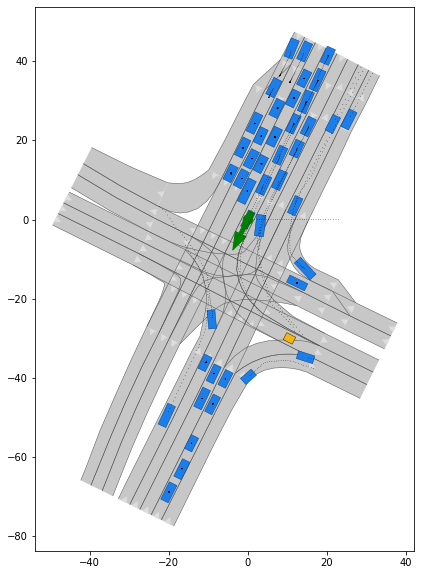

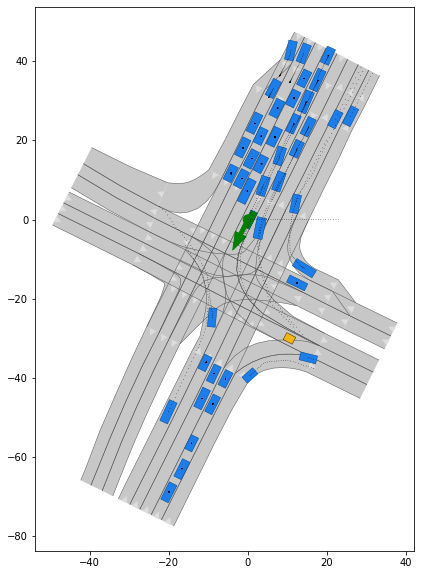

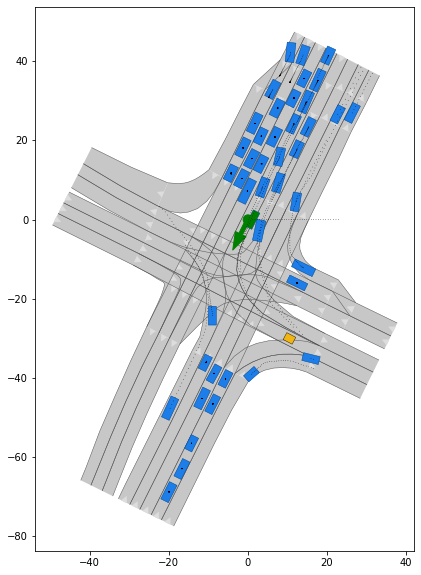

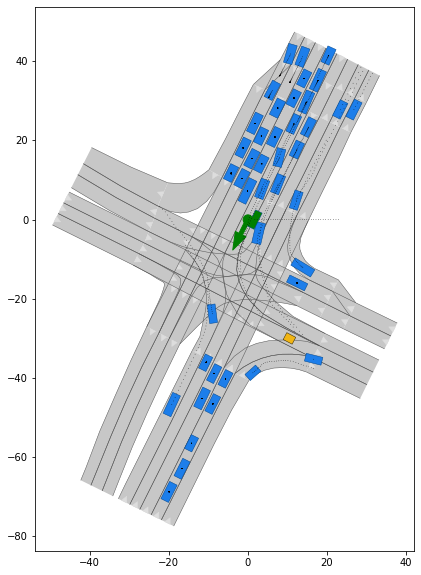

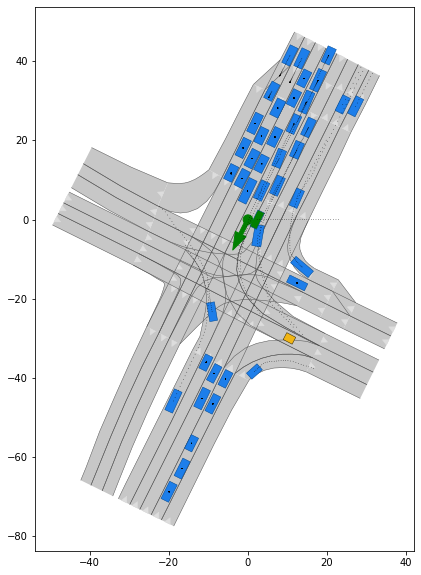

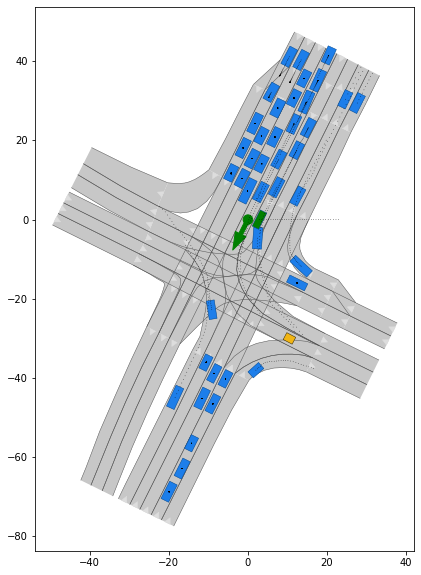

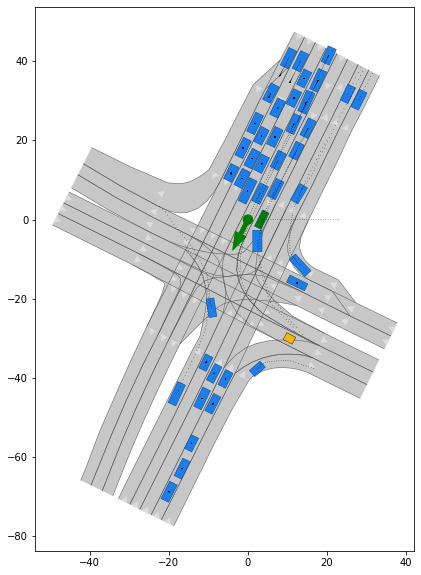

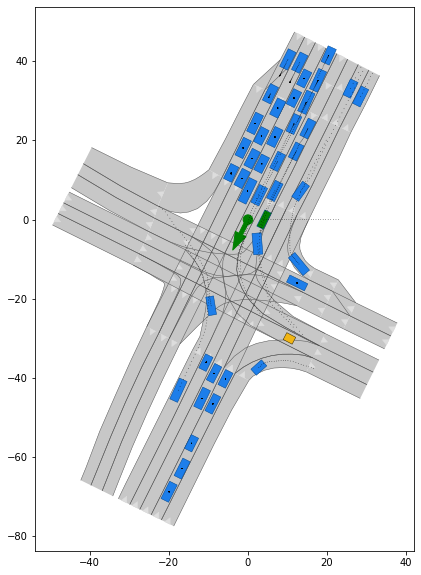

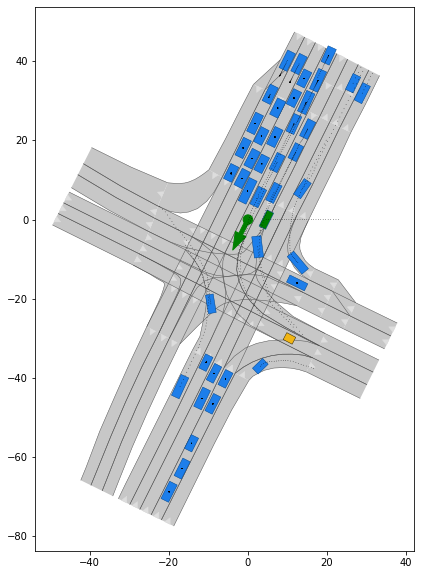

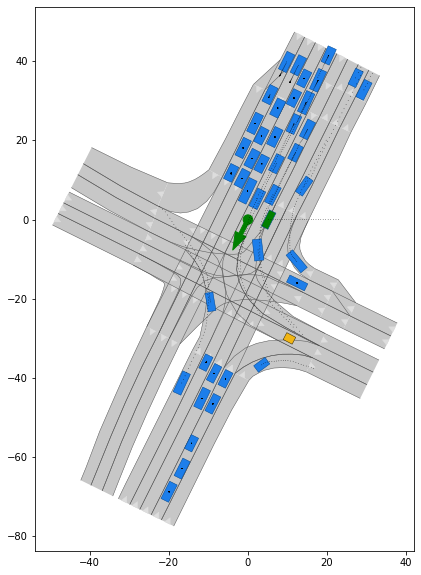

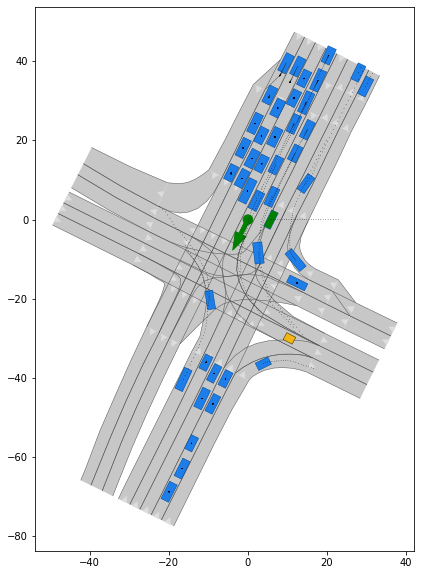

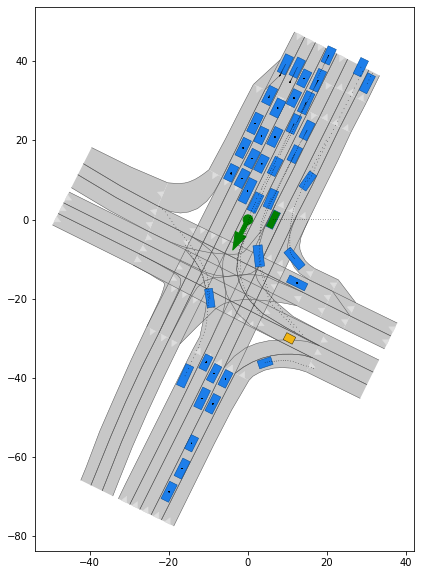

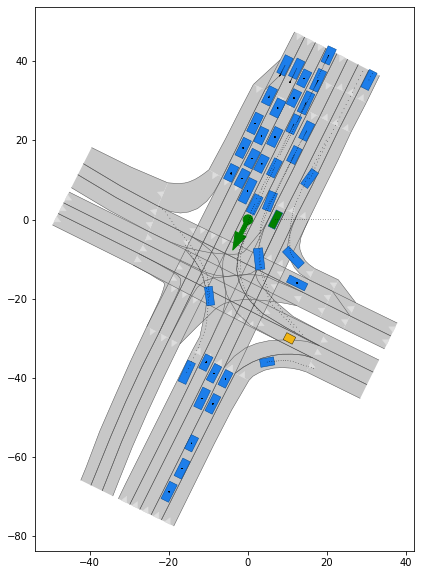

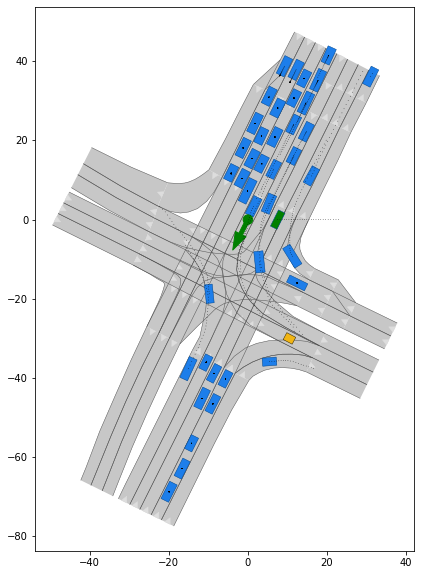

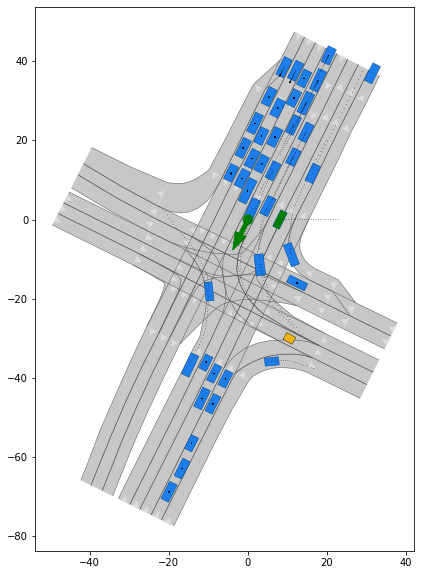

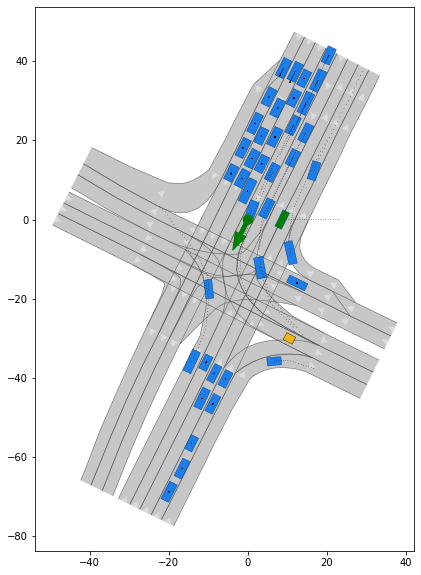

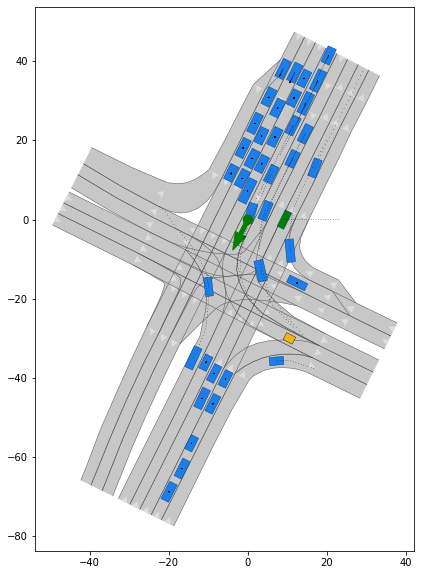

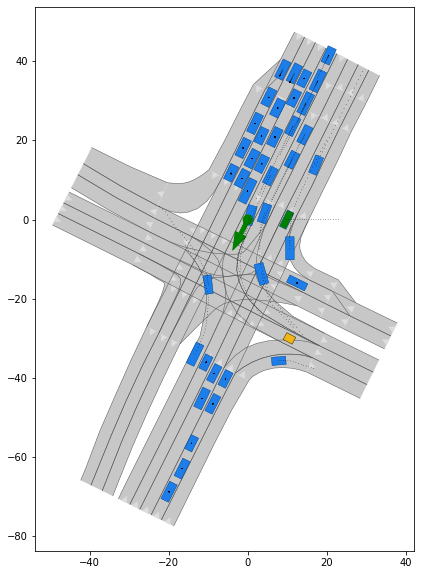

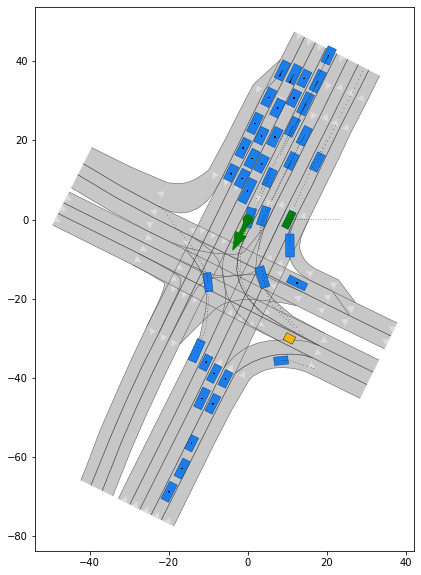

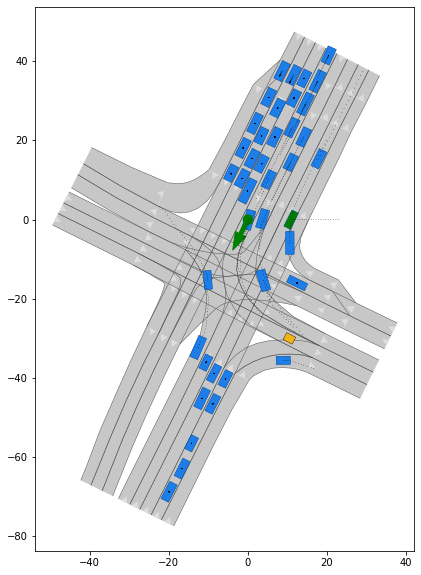

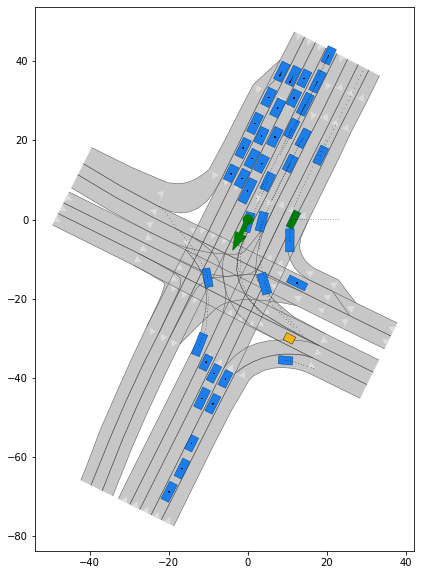

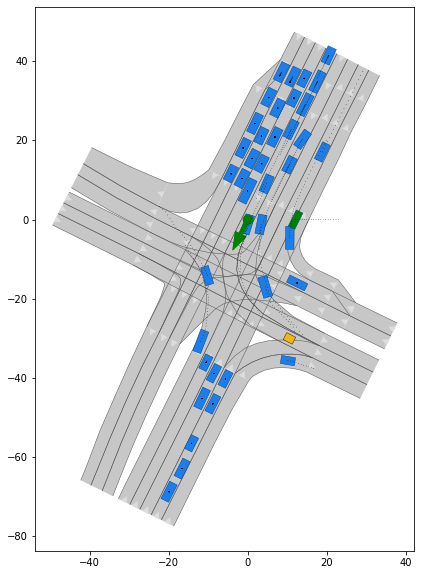

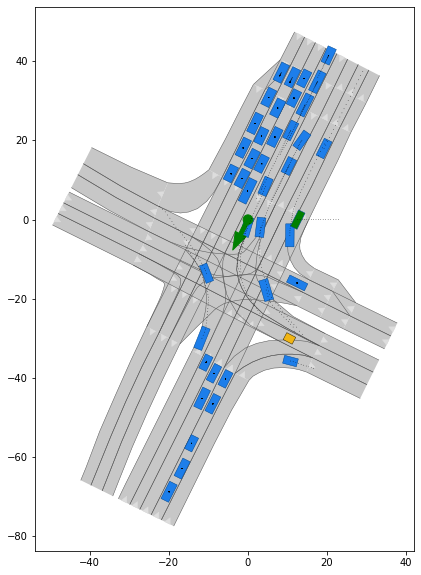

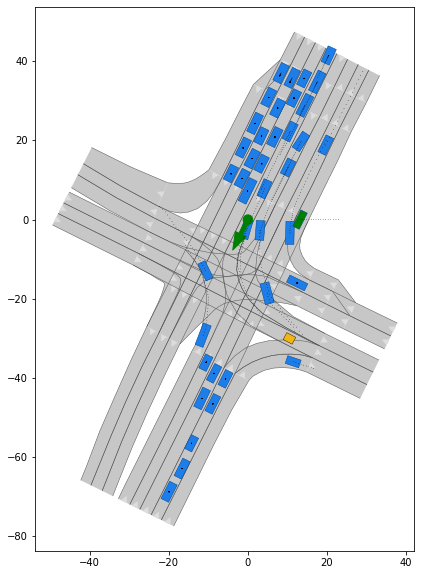

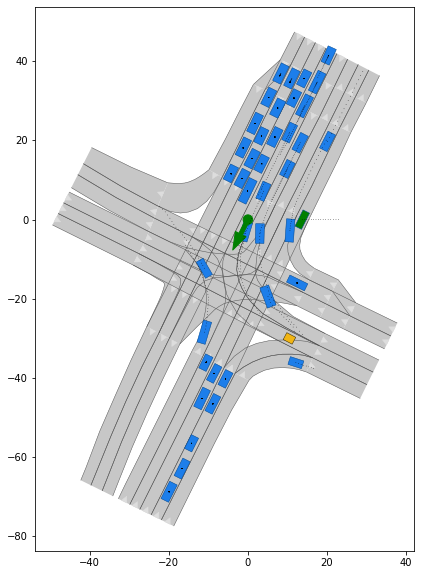

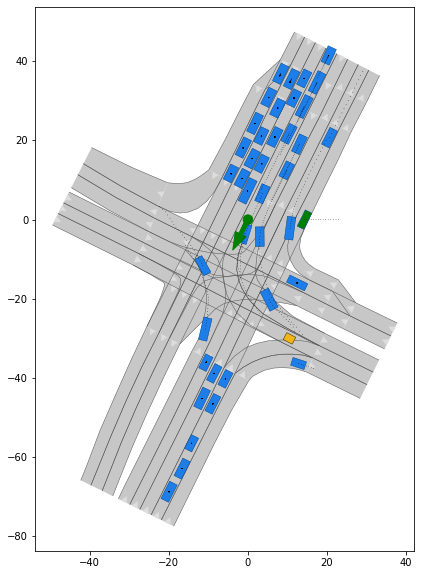

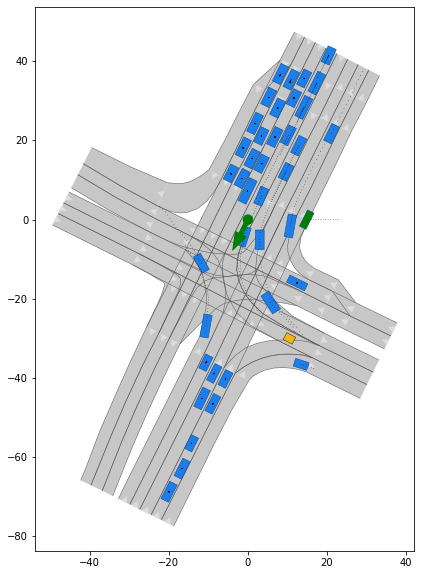

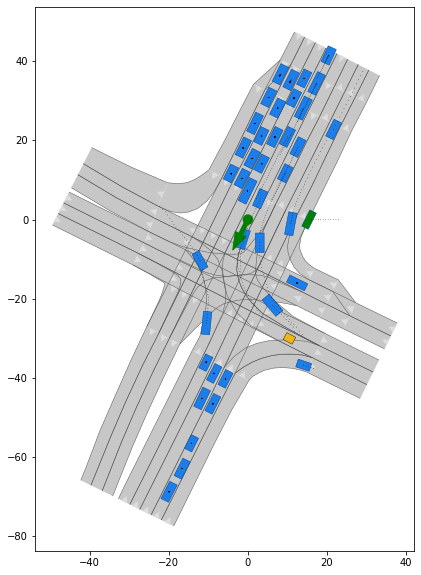

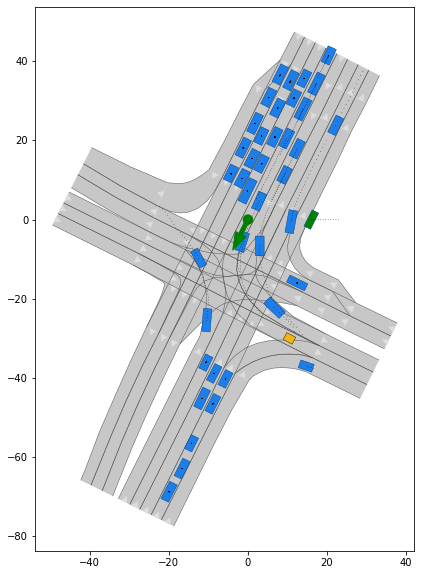

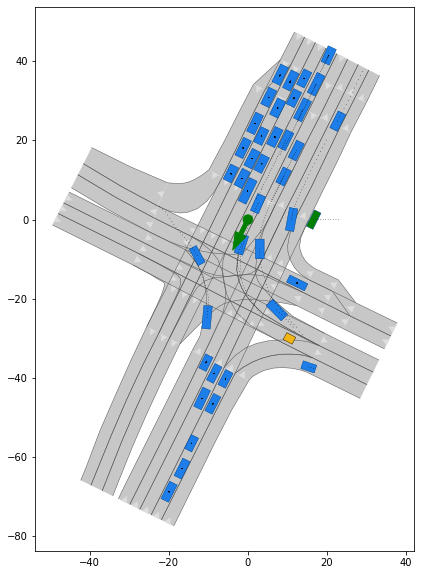

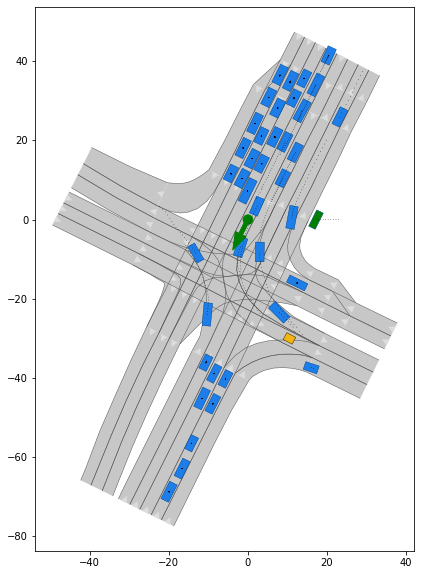

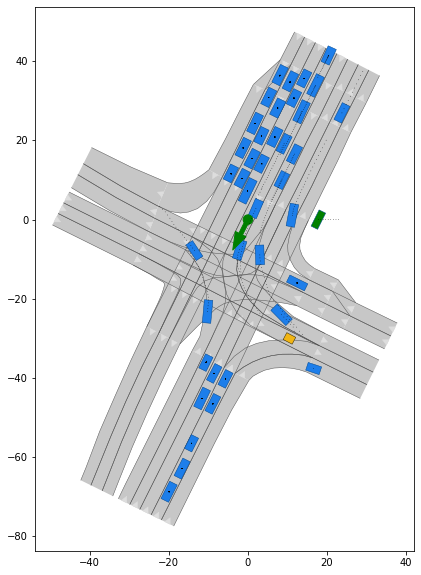

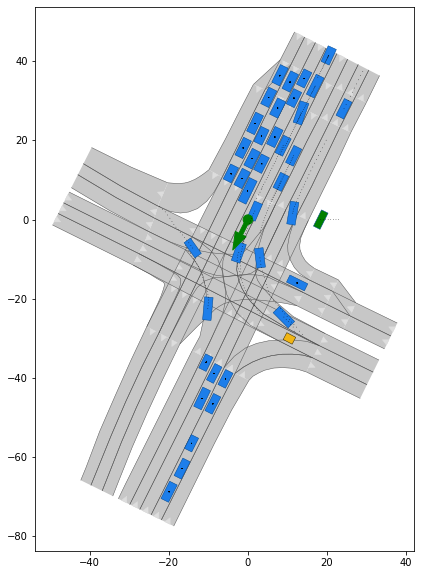

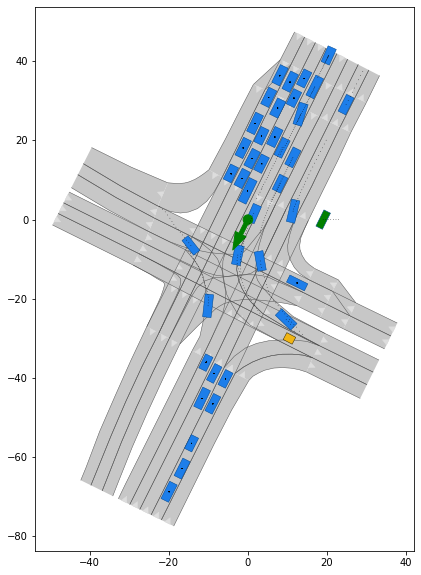

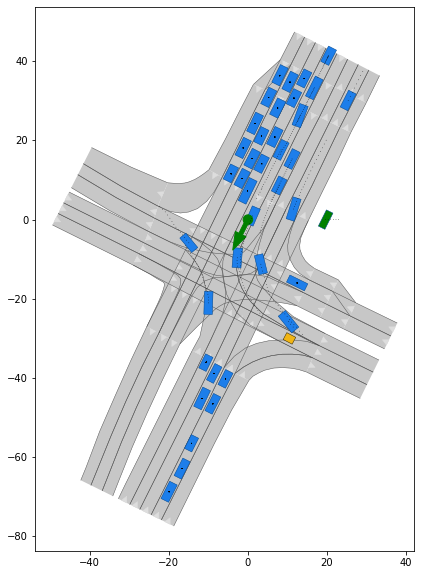

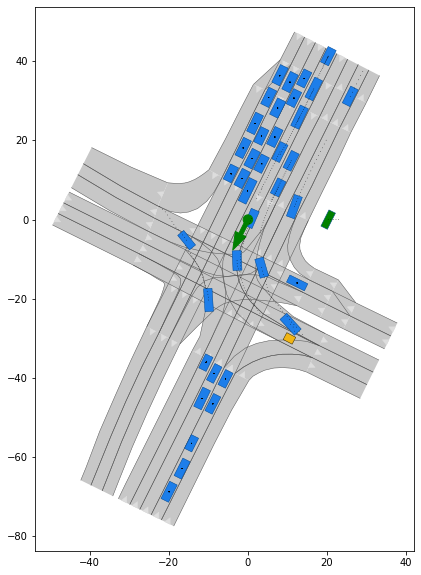

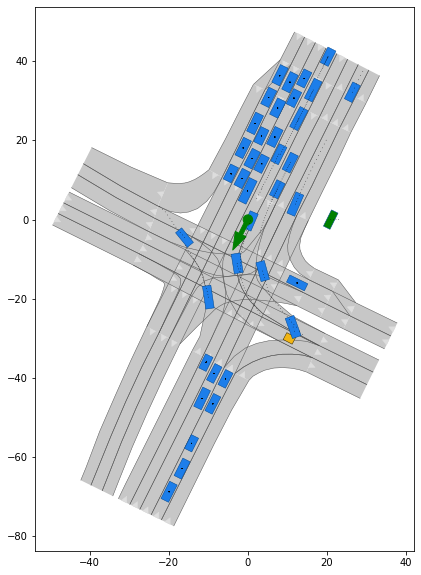

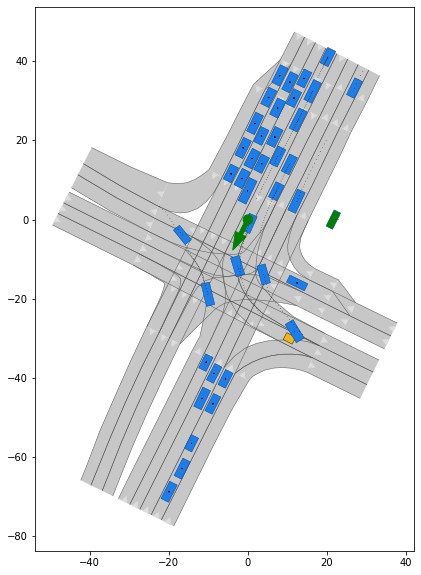

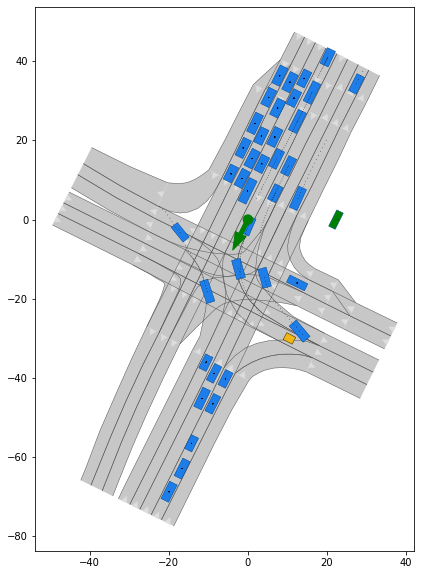

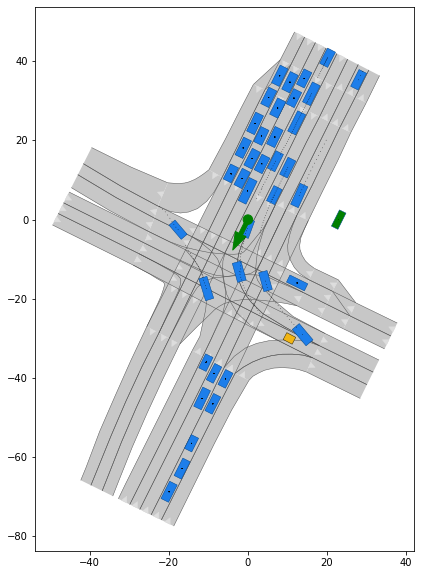

In [13]:
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import DynamicObstacle, ObstacleType
from commonroad.scenario.trajectory import Trajectory,State
from commonroad.prediction.prediction import TrajectoryPrediction
from vehiclemodels import parameters_vehicle3

# generate state list of the ego vehicle's trajectory
state_list = [initial_state]
for i in range(1, N):
    orientation = initial_state.orientation
    # compute new position
    # add new state to state_list    
    state_list.append(State(**{'position': npy.array([s_ego[i],0]), 'orientation': orientation,
                               'time_step': i, 'velocity': v_ego[i]*npy.cos(orientation),
                               'velocity_y': v_ego[i]*npy.sin(orientation)}))

# create the planned trajectory starting at time step 1
ego_vehicle_trajectory = Trajectory(initial_time_step=1, state_list=state_list[1:])
# create the prediction using the planned trajectory and the shape of the ego vehicle

vehicle3 = parameters_vehicle3.parameters_vehicle3()
ego_vehicle_shape = Rectangle(length=vehicle3.l, width=vehicle3.w)
ego_vehicle_prediction = TrajectoryPrediction(trajectory=ego_vehicle_trajectory,
                                              shape=ego_vehicle_shape)

# the ego vehicle can be visualized by converting it into a DynamicObstacle
ego_vehicle_type = ObstacleType.CAR
ego_vehicle = DynamicObstacle(obstacle_id=100, obstacle_type=ego_vehicle_type,
                              obstacle_shape=ego_vehicle_shape, initial_state=initial_state,
                              prediction=ego_vehicle_prediction)

# plot the scenario and the ego vehicle for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    ego_vehicle.draw(rnd, draw_params={'time_begin': i, 'dynamic_obstacle': {
        'vehicle_shape': {'occupancy': {'shape': {'rectangle': {
            'facecolor': 'g'}}}}}})
    planning_problem_set.draw(rnd)
    rnd.render()
    plt.savefig('figure/solution/{}.JPG'.format(i))
    
#plt.savefig('figure/motion.png')

make_gif("./figure/solution")